# Imports

In [5]:
import pandas as pd
from pandas import Timestamp
import numpy as np
from operator import itemgetter
from datetime import datetime
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from ast import literal_eval
import joblib

from tqdm import tqdm
tqdm.pandas()
from scipy import sparse
from imblearn.over_sampling import SMOTENC

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

# Sentiment Analysis

In [ ]:
df = pd.read_csv('/Users/francesco/df2')

In [ ]:
df.shape

In [ ]:
analyzer = SentimentIntensityAnalyzer()
vader_scores = df['text'].map(analyzer.polarity_scores) # Calculate sentiment analysis (2h 18).

In [ ]:
vader_scores.head()

In [ ]:
dvec = DictVectorizer()

vader_scores = dvec.fit_transform(vader_scores) # Sparse matrix
vader_scores

In [ ]:
dvec.feature_names_
for i, col in enumerate(dvec.feature_names_):
    df['vader_{}'.format(col)] = vader_scores[:, i].toarray().ravel()

In [ ]:
df.head()

In [ ]:
df.to_csv('/Users/francesco/df2_sent', encoding='utf-8', index=False) # In case later parts break.

# Part of Speech Tagging

In [ ]:
df = pd.read_csv('/Users/francesco/df2_sent')

In [ ]:
def text_vec(x):
    '''Calculate the POS tags for each word in text.'''
    try:
        return [count for tag, count in sorted(
            add_pos_with_zero_counts(
                Counter(list(zip(*x))[1]), 
                    possible_tags).most_common()
                    )]
    except:
        return ('error')
    
df['text_vector'] = df['tagged_text'].apply(lambda x: text_vec(x))

In [ ]:
df_pos_tags.shape # May need to be saved now to clear memory space

In [ ]:
type(df_pos_tags[0])

In [ ]:
pos_tags = df_pos_tags.progress_apply(lambda x: literal_eval(x)) # Converts strings back into list.

In [ ]:
pos_tags

In [ ]:
tags = []
for i, tag in enumerate(pos_tags):
    try:
        tags.append(np.array(pos_tags[i])[:, 1])
    except:
        tags.append(np.array(pos_tags[0])[:, 1]) #If ever occurs, place in tags of pos_tags(0) - very rare


In [ ]:
counts = [dict(Counter(tag)) for tag in tags] # Count the tags.

In [ ]:
df_pos_tags_count = pd.DataFrame(counts)

In [ ]:
df_pos_tags_count.head()

In [ ]:
df_pos_tags_count.fillna(0, inplace=True) # Turn to sparse. 

In [ ]:
df_pos_tags_count.shape

In [ ]:
df_pos_tags_count.to_csv('/Users/francesco/df_pos_tags_count_8', encoding='utf-8', index=False) # Save for later

In [ ]:
df_sent = pd.read_csv('/Users/francesco/df2_sent')

In [ ]:
df = pd.concat([df_sent, df_pos_tags_count], axis=1)

In [ ]:
df.drop(['#', '$', "''", ':', '``'], axis=1, inplace=True)

In [ ]:
df.to_csv('/Users/francesco/df2_sent_pos', encoding='utf-8', index=False) # Final dataframe for modelling.

# Pre Modelling

In [3]:
df = pd.read_csv('/Users/francesco/df2_sent_pos')

In [4]:
df.head()

author  created_utc subreddit  num_comments  score  \
0         CocoDeCongo   1483302020   Anxiety             1      1   
1             diazzle   1483334100   Anxiety             2      2   
2       OpheliaXavier   1483461581   Anxiety             1      3   
3  anxiousthrowaway64   1483469503   Anxiety            11      6   
4         Pain_Austen   1483480485   Anxiety             0      2   

                  date                                               text  \
0  2017-01-01 20:20:20  people who have lived with anxiety long term w...   
1  2017-01-02 05:15:00  arm body twitches whenever i am having about t...   
2  2017-01-03 16:39:41  coping techniques i am a freshman in high scho...   
3  2017-01-03 18:51:43  at what point do you surrender to the anxiety ...   
4  2017-01-03 21:54:45  shower anxiety - any tips i have been having s...   

   word_count  vader_compound  vader_neg  ...    VB  VBD   VBG  VBN   VBP  \
0         157         -0.2757      0.154  ...   4.0  1.0   5.0  9.0  14.0   
1          28         -0.9036      0.336  ...   3.0  0.0   1.0  0.0   3.0   
2         183          0.9840      0.062  ...  17.0  6.0   6.0  1.0  13.0   
3         270          0.8271      0.089  ...  18.0  3.0   7.0  9.0  15.0   
4         395         -0.9024      0.120  ...  14.0  2.0  11.0  8.0  30.0   

    VBZ  WDT   WP  WP$  WRB  
0   7.0  0.0  5.0  0.0  3.0  
1   2.0  0.0  0.0  0.0  2.0  
2  11.0  0.0  0.0  0.0  1.0  
3  10.0  0.0  2.0  0.0  0.0  
4  17.0  4.0  0.0  0.0  3.0  

[5 rows x 48 columns]

In [5]:
df.subreddit.value_counts()

depression      413484
SuicideWatch    159198
Anxiety         141082
bipolar          71875
Name: subreddit, dtype: int64

In [6]:
df.shape

(785639, 48)

In [8]:
df.columns

Index(['author', 'created_utc', 'subreddit', 'num_comments', 'score', 'date',
       'text', 'word_count', 'vader_compound', 'vader_neg', 'vader_neu',
       'vader_pos', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS',
       'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$',
       'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN',
       'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'],
      dtype='object')

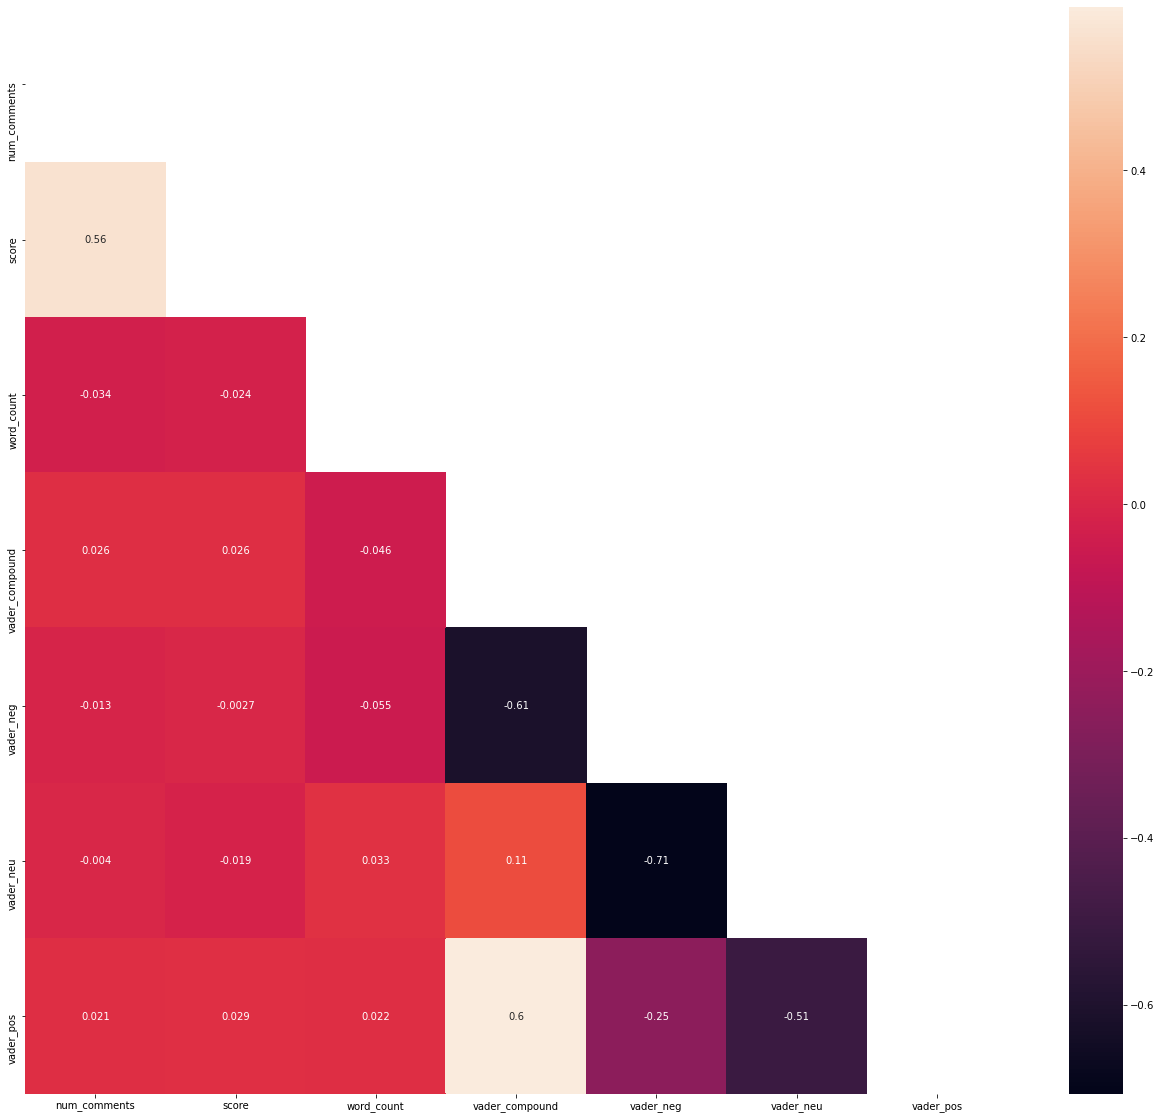

In [9]:
'''
Heat Map / correlation 
'''
test_corr = df[['num_comments', 'score', 'word_count',
               'vader_compound', 'vader_neg', 'vader_neu', 'vader_pos']].corr()

# Set the  matplotlib figure size:
fig, ax = plt.subplots(figsize=(22, 20))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(test_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.heatmap(test_corr, mask=mask, annot=True, ax=ax)
ax.set_ylim([test_corr.shape[1], 0])
plt.show()

In [10]:
df.drop(['vader_neg', 'vader_neu', 'vader_pos'], axis=1, inplace=True)

In [11]:
df.shape

(785639, 45)

In [12]:
df.columns

Index(['author', 'created_utc', 'subreddit', 'num_comments', 'score', 'date',
       'text', 'word_count', 'vader_compound', 'CC', 'CD', 'DT', 'EX', 'FW',
       'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT',
       'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB',
       'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'],
      dtype='object')

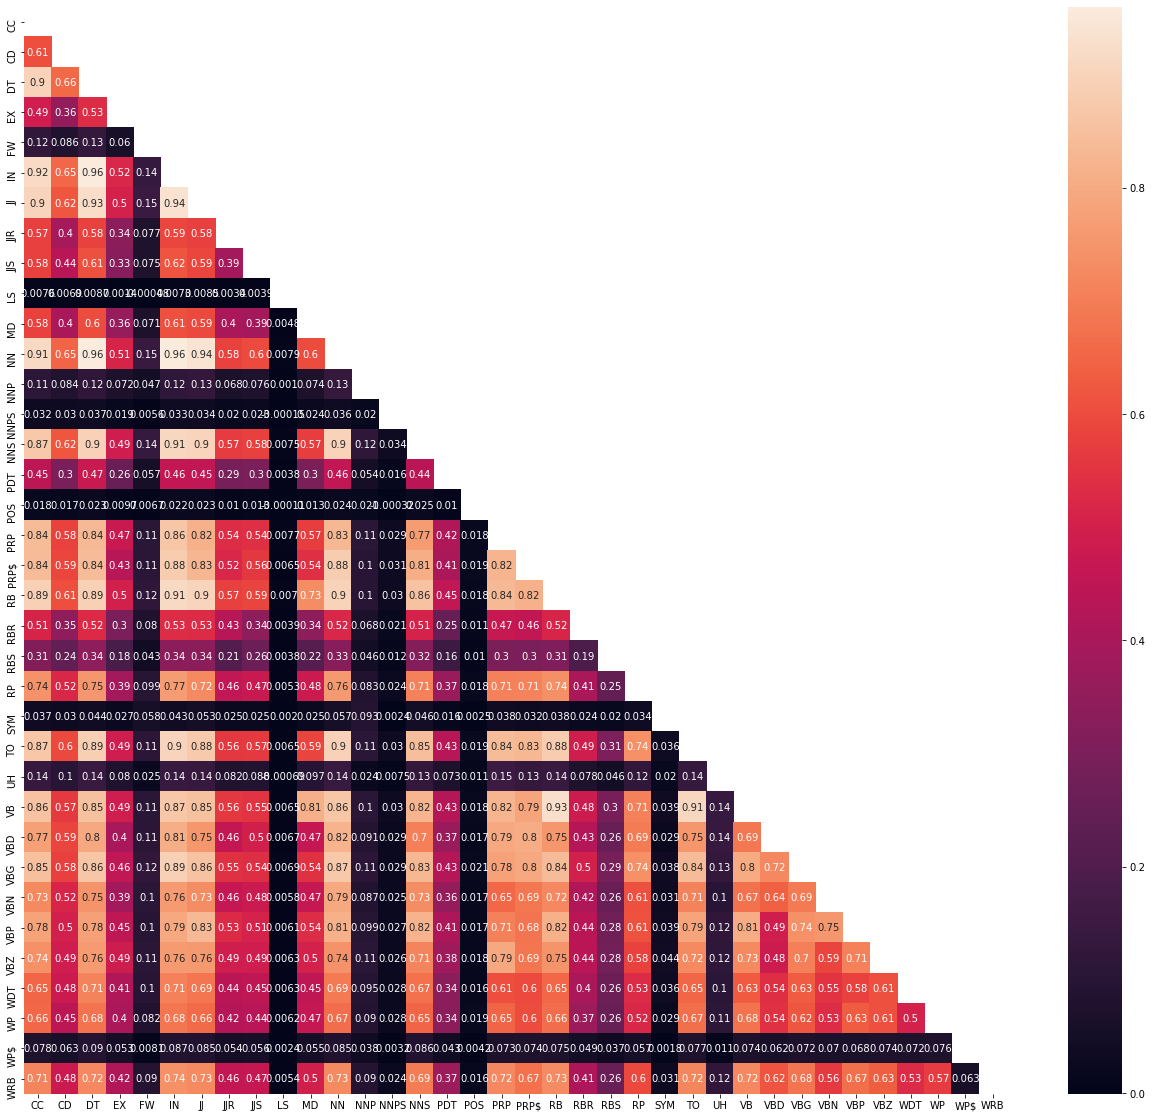

In [13]:
'''
Heat Map / correlation 
'''
corr_mat = df.loc[:, df.columns[9:]].corr()

# Set the  matplotlib figure size:
fig, ax = plt.subplots(figsize=(22, 20))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.heatmap(corr_mat, mask=mask, annot=True, ax=ax)
ax.set_ylim([corr_mat.shape[1], 0])
plt.show()

In [14]:

upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['IN', 'NN']

In [15]:
df.drop(to_drop, axis=1, inplace=True)

In [16]:
df.shape

(785639, 43)

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score

In [18]:
X = pd.concat([df['text'], df.loc[:, ~df.columns.isin(['author', 'created_utc', 'subreddit', 'date', 'text'])].astype(float)], axis=1)
y = df['subreddit']

# Word2Vec Method

## Training

In [22]:
import gensim
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("/Users/francesco/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [23]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.vectors_norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [24]:
from nltk.tokenize import WordPunctTokenizer

def w2v_tokenize_text(text):
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(('depression', 'depressive', 'depressed', 'anxiety', 'anxious', 
                      'suicide', 'suicidal', 'bipolar', 'bi', 'polar'))

    
#     'depression', 'depressive', 'depressed', 'anxiety', 'anxious', 
#                       'panic', 'attack','suicide', 'suicidal', 'bipolar', 'manic', 'mania', 'hypomania', 
#                       'attacks', 'lithium','mg', 'die', 'kill', 'disorder', 'episode', 'episodes', 'polar', 'bi'
            
    tokens = []
    [tokens.append(word) for word in text.split() if word not in stopwords]
    return tokens

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size= 0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(628511, 39)
(157128, 39)
(628511,)
(157128,)


In [26]:
X_train_tokenized = X_train.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
X_test_tokenized = X_test.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

#9mins

In [27]:
X_train_word_average = word_averaging_list(wv,X_train_tokenized)
X_test_word_average = word_averaging_list(wv,X_test_tokenized)

#3mins

In [28]:
print(X_train_word_average.shape)
print(X_test_word_average.shape)
print(y_train.shape)
print(y_test.shape)

(628511, 300)
(157128, 300)
(628511,)
(157128,)


## Spatial Graph

In [ ]:
w2v_tokenize_text(r['text'])
word_averaging_list(wv,X_train_tokenized)

In [31]:
words_array = [word for word in X_train_tokenized]
words_flat = [item for sublist in words_array for item in sublist]

In [110]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [wv[word] for word in words_flat[0:20000] if word in wv.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words_flat[0:20000] if word in wv.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df_word_wv = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df_word_wv.head(5)

0         1         2         3         4         5    \
currently  -0.009274 -0.064243  0.038753  0.005621 -0.048079  0.121855   
bored       0.081014  0.029694 -0.060417  0.075865 -0.072432  0.047029   
everything  0.049014 -0.016196 -0.056259  0.009696 -0.071603  0.005860   
things      0.059385  0.140602  0.004230  0.075104 -0.084711 -0.062441   
loved       0.014694 -0.034877  0.053112  0.087813  0.010357  0.044969   

                 6         7         8         9    ...       290       291  \
currently   0.005984 -0.036266  0.115223 -0.084138  ... -0.069631 -0.053881   
bored       0.078611 -0.029179  0.002253  0.044969  ...  0.023171  0.091312   
everything  0.093765 -0.074586 -0.059243 -0.038358  ... -0.068193  0.036227   
things      0.058511 -0.021505 -0.049123 -0.014300  ...  0.010480  0.005676   
loved       0.074357 -0.041428 -0.026202  0.058778  ... -0.101268 -0.010180   

                 292       293       294       295       296       297  \
currently  -0.010103  0.018237  0.002422  0.054296  0.025801  0.059270   
bored      -0.030895 -0.013989 -0.095431 -0.022828 -0.057328 -0.022485   
everything -0.064783  0.009377 -0.069898 -0.003117  0.080553 -0.024081   
things     -0.076414 -0.049997 -0.034277  0.012281  0.111783  0.032312   
loved      -0.114723 -0.049218 -0.088167 -0.021068 -0.059486 -0.104100   

                 298       299  
currently  -0.018962 -0.022692  
bored      -0.042567  0.025231  
everything  0.000832 -0.077996  
things      0.076414 -0.009661  
loved       0.028681 -0.043021  

[5 rows x 300 columns]

In [111]:
df_word_wv = df_word_wv.append(pd.DataFrame(wv['anxiety'].reshape(1,-1)))
df_word_wv.rename(index = {0:'anxiety'}, inplace=True)

In [112]:
df_word_wv = df_word_wv.append(pd.DataFrame(wv['depression'].reshape(1,-1)))
df_word_wv.rename(index = {0:'depression'}, inplace=True)

In [113]:
df_word_wv = df_word_wv.append(pd.DataFrame(wv['bipolar'].reshape(1,-1)))
df_word_wv.rename(index = {0:'bipolar'}, inplace=True)

In [114]:
df_word_wv = df_word_wv.append(pd.DataFrame(wv['suicide'].reshape(1,-1)))
df_word_wv.rename(index = {0:'suicide'}, inplace=True)

In [115]:
df_word_wv.tail()

0         1         2         3         4         5    \
currently   -0.009274 -0.064243  0.038753  0.005621 -0.048079  0.121855   
bored        0.081014  0.029694 -0.060417  0.075865 -0.072432  0.047029   
everything   0.049014 -0.016196 -0.056259  0.009696 -0.071603  0.005860   
things       0.059385  0.140602  0.004230  0.075104 -0.084711 -0.062441   
loved        0.014694 -0.034877  0.053112  0.087813  0.010357  0.044969   
...               ...       ...       ...       ...       ...       ...   
pessimistic  0.082040 -0.017019  0.018401  0.003164 -0.039856  0.072149   
anxiety      0.085094  0.033572 -0.077117  0.035733 -0.093737 -0.016537   
depression  -0.038026 -0.053451 -0.130114  0.078191  0.027031  0.070249   
bipolar     -0.127553 -0.039677 -0.059368  0.058486 -0.129904  0.064071   
suicide     -0.074038  0.011997 -0.082813  0.052649 -0.010626 -0.016659   

                  6         7         8         9    ...       290       291  \
currently    0.005984 -0.036266  0.115223 -0.084138  ... -0.069631 -0.053881   
bored        0.078611 -0.029179  0.002253  0.044969  ...  0.023171  0.091312   
everything   0.093765 -0.074586 -0.059243 -0.038358  ... -0.068193  0.036227   
things       0.058511 -0.021505 -0.049123 -0.014300  ...  0.010480  0.005676   
loved        0.074357 -0.041428 -0.026202  0.058778  ... -0.101268 -0.010180   
...               ...       ...       ...       ...  ...       ...       ...   
pessimistic  0.098332  0.044511  0.176881  0.044802  ... -0.011928  0.054694   
anxiety     -0.041882 -0.028753  0.105038 -0.036065  ... -0.044542 -0.074790   
depression  -0.026114 -0.025656  0.092240 -0.084910  ...  0.013973 -0.000128   
bipolar      0.020132 -0.046436 -0.027333 -0.050257  ... -0.005878  0.001414   
suicide      0.041132 -0.015013  0.175498 -0.020018  ...  0.044149 -0.075135   

                  292       293       294       295       296       297  \
currently   -0.010103  0.018237  0.002422  0.054296  0.025801  0.059270   
bored       -0.030895 -0.013989 -0.095431 -0.022828 -0.057328 -0.022485   
everything  -0.064783  0.009377 -0.069898 -0.003117  0.080553 -0.024081   
things      -0.076414 -0.049997 -0.034277  0.012281  0.111783  0.032312   
loved       -0.114723 -0.049218 -0.088167 -0.021068 -0.059486 -0.104100   
...               ...       ...       ...       ...       ...       ...   
pessimistic  0.059639 -0.073604 -0.000178 -0.028947 -0.087277  0.045093   
anxiety     -0.031246 -0.071466  0.006606  0.059832 -0.051854  0.076120   
depression  -0.060475 -0.029169 -0.059559 -0.003952 -0.062308  0.075747   
bipolar     -0.017708  0.072006 -0.043497 -0.091697  0.018589  0.097575   
suicide     -0.054295  0.043874 -0.110234  0.054569  0.000149 -0.014808   

                  298       299  
currently   -0.018962 -0.022692  
bored       -0.042567  0.025231  
everything   0.000832 -0.077996  
things       0.076414 -0.009661  
loved        0.028681 -0.043021  
...               ...       ...  
pessimistic  0.074476 -0.029383  
anxiety      0.057173 -0.009847  
depression   0.090408  0.006452  
bipolar      0.110507  0.032476  
suicide     -0.094878 -0.005279  

[4008 rows x 300 columns]

In [117]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 35)

tsne_df = tsne.fit_transform(df_word_wv)

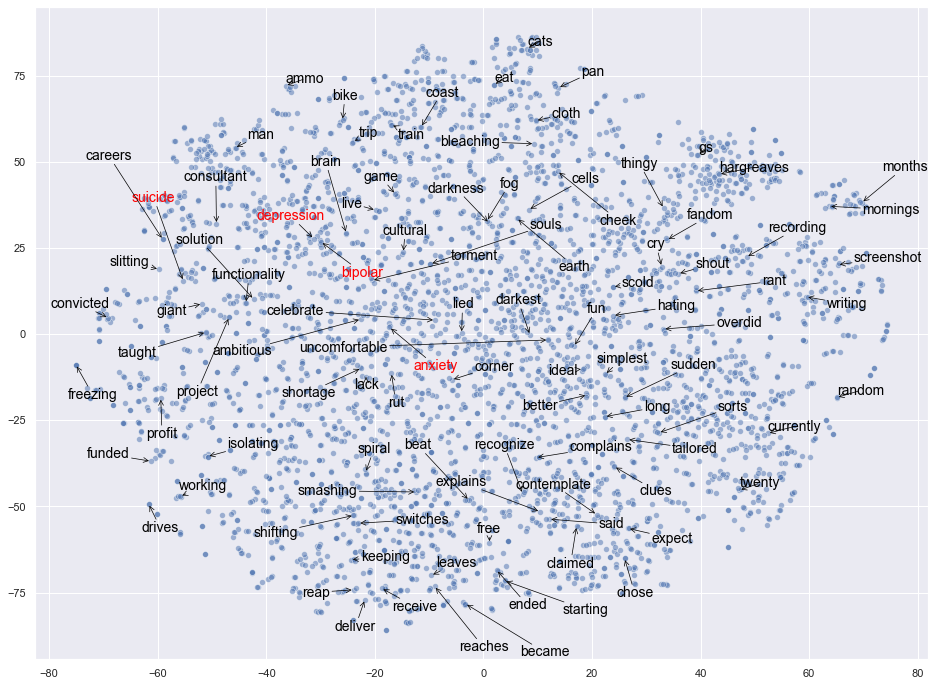

In [169]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (16, 12))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
texts_extra = []

words_to_plot = list(np.arange(0, len(df_word_wv)-4, 42))
words_to_plot_extra = [4004, 4005, 4006, 4007]

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df_word_wv.index[word], fontsize = 14, color = 'black'))

for word in words_to_plot_extra:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df_word_wv.index[word], fontsize = 14, color = 'red'))

adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,3),
            arrowprops = dict(arrowstyle = "->", color = 'black', lw = 0.7))

plt.show()

## PCA

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=X_train_word_average.shape[1]-1, random_state=1)

X_train_pca = pca.fit_transform(X_train_word_average)

print(pca.explained_variance_ratio_.sum())

0.9998455761464332


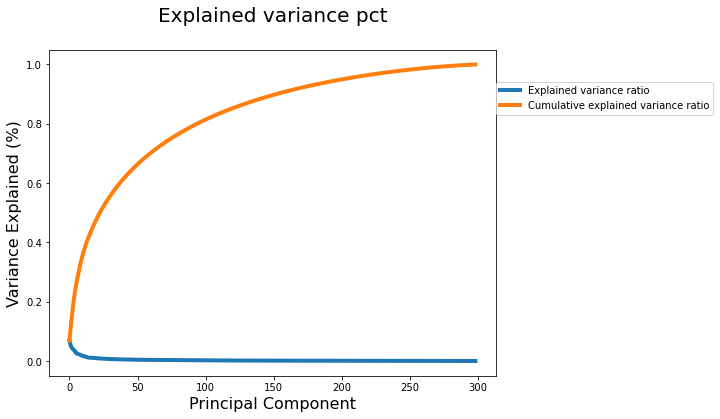

In [30]:
#Scree plot
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, lw=4, label='Explained variance ratio')
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=4,
         label='Cumulative explained variance ratio')
plt.legend(loc=(1, 0.8))
ax.set_title('Explained variance pct\n', fontsize=20)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Variance Explained (%)', fontsize=16)
plt.show()


In [31]:
pca_var_ratios = pca.explained_variance_ratio_

In [32]:
def select_n_components(var_ratio, goal_var: float) -> int:
    total_variance = 0.0
    n_components = 0
    
    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1

        if total_variance >= goal_var:
            break

    return n_components

In [33]:
select_n_components(pca_var_ratios, 0.99) 

268

In [34]:
pca = PCA(n_components=select_n_components(pca_var_ratios, 0.99) , random_state=1)

X_train_word_average_pca = pca.fit_transform(X_train_word_average)
X_test_word_average_pca = pca.transform(X_test_word_average)

In [35]:
X_train_w2v = np.concatenate([X_train.loc[:, ~X_train.columns.isin(['text'])], X_train_word_average_pca], axis=1)
X_test_w2v = np.concatenate([X_test.loc[:, ~X_train.columns.isin(['text'])], X_test_word_average_pca], axis=1)

## Standard Scaler

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train_w2v) 
X_test_std = scaler.transform(X_test_w2v) 

In [196]:
print(X_train_std.shape)
print(X_test_std.shape)
print(y_train.shape)
print(y_test.shape)

(628511, 306)
(157128, 306)
(628511,)
(157128,)


## Grid Search

In [201]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import mean_squared_error

In [ ]:
def docm(y_true, y_pred, labels=None):
    '''Creates Document Matrix'''
    cm = confusion_matrix(y_true, y_pred)
    if gs.classes_ is not None:
        cols = ['p_' + c for c in gs.classes_]
        df = pd.DataFrame(cm, index=gs.classes_, columns=cols)
    else:
        cols = ['p_' + str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=gs.classes_)
    return df

In [ ]:
'''Models and their grid-search parameters.'''
########################################################################
LR = LogisticRegression(multi_class = 'ovr', 
                        random_state = 1,
                        n_jobs=16
                       )
LR_params = {'C': np.logspace(-5, 5, 5),
             'solver': ['lbfgs', 'saga'],
             'max_iter': [500, 1000],
             'penalty': ['l1', 'l2']
            }

########################################################################

SVM_SGD = SGDClassifier(penalty='l2',
                        random_state=1,
                        learning_rate='optimal',
                        tol=None,
                        n_jobs=16
                       )
SVM_SGD_params = {'loss': ['hinge', 'squared_hinge'],
                  'alpha': np.linspace(1e-3, 0.5, 5),
                  'max_iter': [500, 1000],
                  'penalty': ['l1', 'l2', 'elasticnet']
                 }

########################################################################

KNC = KNeighborsClassifier(n_jobs=16
                          )
KNC_params = {'algorithm': ['auto'],
              'n_neighbors': [2, 10, 20],
              'p': [1, 2],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']
             }

########################################################################

RFC = RandomForestClassifier(random_state=1,
                             n_estimators=100,
                             n_jobs=16
                            )
RFC_params = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 5],
              'ccp_alpha': np.linspace(0., 0.5, 3)
             }

########################################################################

ETC = ExtraTreesClassifier(random_state=1,
                           n_estimators=100,
                           n_jobs=16
                          )
ETC_params = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 5],
              'ccp_alpha': np.linspace(0., 0.5, 3)
             }

########################################################################

DTC = DecisionTreeClassifier(random_state=1
                            )
DTC_params = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 5],
              'ccp_alpha': np.linspace(0., 0.5, 3)
             }

########################################################################

In [ ]:
'''Grid Search'''

models = {'LogisticRegression': LR, 
          'SGDClassifier': SVM_SGD, 
          'KNeighborsClassifier': KNC,
          'DecisionTreeClassifier': DTC, 
          'RandomForestClassifier': RFC, 
          'ExtraTreeClassifier': ETC
         }

params = {'LogisticRegression': LR_params, 
          'SGDClassifier': SVM_SGD_params, 
          'KNeighborsClassifier': KNC_params,
          'DecisionTreeClassifier': DTC_params, 
          'RandomForestClassifier': RFC_params, 
          'ExtraTreeClassifier': ETC_params
         }

score_list = []
for name, model in models.items():
    accuracy = 0
    gs = GridSearchCV(estimator = model, 
                      param_grid = params[name], 
                      cv=5, 
                      verbose=1,
                      n_jobs=16
                     )
    
    gs.fit(X_train_std, y_train)
    
    best_est = gs.best_estimator_
    best_score = gs.best_score_ 
    best_params = gs.best_params_
    
    train_score = gs.score(X_train_std, y_train)
    test_score = gs.score(X_test_std, y_test)
    
    test_predictions = gs.predict(X_test_std)
    
    gs_results = pd.DataFrame(gs.cv_results_)
    score_list.append([name, train_score, test_score, best_score]) # Append main results of best estimator.
    
    joblib.dump(gs, f'{name}' + '_model.jlib') # Save model.
    gs_results.to_csv(f'{name}' + '_results', encoding='utf-8', index=False) # Export results to csv.
         
    # Print reports.
    print(name)
    print()
    print(best_score)
    print()
    print(classification_report(y_test, test_predictions, target_names=gs.classes_))
    print()
    print(docm(y_test, test_predictions))
    print()
    print('-'*80)

In [ ]:
df_scores = pd.DataFrame(score_list, columns=['model', 'train_score', 'test_score', 'best_score']) # Dataframe of main scores.
df_scores

df_scores.to_csv('/Users/francesco/df_scores', encoding='utf-8', index=False)

## Neural Network

In [39]:
d = dict(zip(df.subreddit.unique(), range(0,4)))
d

{'Anxiety': 0, 'bipolar': 1, 'depression': 2, 'SuicideWatch': 3}

In [ ]:
y_train = y_train.map(d, na_action='ignore')
y_test = y_test.map(d, na_action='ignore')

In [43]:
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
np.random.seed(1337)

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import multi_gpu_model 

In [45]:
keras.backend.backend()

'plaidml'

In [235]:
model = keras.Sequential()
alpha = 0.001

model.add(keras.layers.Dense(256, activation='relu', input_shape=(X_train_std.shape[1], ), kernel_regularizer=keras.regularizers.l2(alpha))) 
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(alpha)))
# model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(alpha)))
model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(alpha)))

model.add(keras.layers.Dense(4, activation='softmax', kernel_regularizer=keras.regularizers.l2(alpha)))

optimizer = keras.optimizers.SGD(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [236]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

EPOCHS = 100

history = model.fit(
  X_train_std, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=1, callbacks=[early_stop], batch_size=256)

Train on 502808 samples, validate on 125703 samples
Epoch 1/100
502808/502808 [==============================] - 21s 41us/step - loss: 1.0196 - acc: 0.6511 - val_loss: 0.8747 - val_acc: 0.6646
Epoch 2/100
502808/502808 [==============================] - 17s 34us/step - loss: 0.8609 - acc: 0.6695 - val_loss: 0.8692 - val_acc: 0.6651
Epoch 3/100
502808/502808 [==============================] - 18s 36us/step - loss: 0.8537 - acc: 0.6727 - val_loss: 0.8584 - val_acc: 0.6713
Epoch 4/100
502808/502808 [==============================] - 18s 36us/step - loss: 0.8504 - acc: 0.6745 - val_loss: 0.8486 - val_acc: 0.6743
Epoch 5/100
502808/502808 [==============================] - 17s 35us/step - loss: 0.8494 - acc: 0.6757 - val_loss: 0.8490 - val_acc: 0.6777
Epoch 6/100
502808/502808 [==============================] - 17s 35us/step - loss: 0.8483 - acc: 0.6763 - val_loss: 0.8626 - val_acc: 0.6713
Epoch 7/100
502808/502808 [==============================] - 17s 34us/step - loss: 0.8475 - acc: 0.676

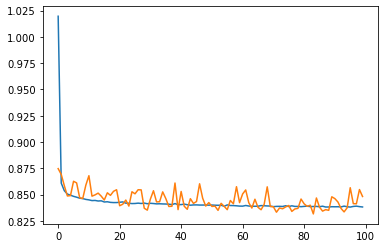

In [238]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [239]:
predicitions = model.predict(X_test_std)

In [240]:
model.metrics_names

['loss', 'acc']

In [241]:
model.evaluate(X_test_std, y_test, verbose=2)

[0.846326370369386, 0.6728781630263225]

In [242]:
accuracy_score(y_test, predicitions.argmax(axis=1))

0.6728781630263225

## Visualise Results

In [99]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [53]:
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if model.classes_ is not None:
        cols = ['p_' + c for c in model.classes_]
        df = pd.DataFrame(cm, index=model.classes_, columns=cols)
    else:
        cols = ['p_' + str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=model.classes_)
    return df

In [82]:
inv_d = {v: k for k, v in d.items()}
inv_d

{0: 'Anxiety', 1: 'bipolar', 2: 'depression', 3: 'SuicideWatch'}

In [94]:
y_test = y_test.map(inv_d, na_action='ignore')
y_test

26181       depression
651520    SuicideWatch
148228         Anxiety
362498      depression
9594        depression
              ...     
365813    SuicideWatch
206708      depression
417665      depression
581006      depression
270883    SuicideWatch
Name: subreddit, Length: 157128, dtype: object

In [149]:
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if d.keys() is not None:
        cols = [c for c in d.keys()]
        df = pd.DataFrame(cm, index=d.keys(), columns=cols)
    else:
        cols = [str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=d.keys())
    return df

In [481]:
wv.most_similar(['depression'])

[('bipolar_disorder', 0.6819544434547424),
 ('depression_anxiety', 0.6687219738960266),
 ('depressive_illness', 0.6607029438018799),
 ('mental_illness', 0.6513590216636658),
 ('psychosis', 0.6443452835083008),
 ('alcoholism', 0.6437938213348389),
 ('depressive', 0.6421664953231812),
 ('depressive_illnesses', 0.6419422030448914),
 ('bipolar_depression', 0.6365950107574463),
 ('bi_polar_disorder', 0.6346871256828308)]

In [471]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import itertools
    plt.figure(figsize=(13, 13))
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('BuGn')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.title('Confusion Matrix', fontsize=38, color='orange')
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=18)
    plt.tight_layout()
    plt.savefig("/Users/francesco/cmat_.png", transparent=False, dpi=300)
    
    plt.show()

<Figure size 936x936 with 0 Axes>

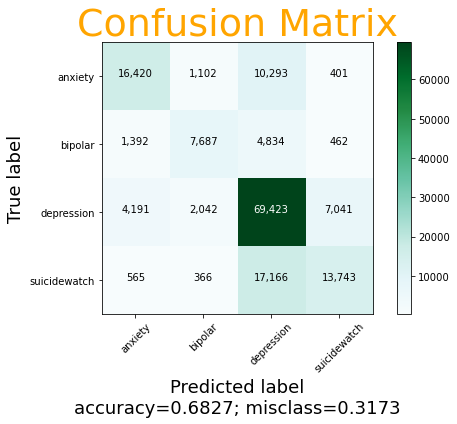

In [472]:
plot_confusion_matrix(cm           = np.array([[16420,  1102,   10293, 401],
                                              [1392,  7687,  4834, 462],
                                              [4191,  2042, 69423, 7041],
                                              [565, 366, 17166, 13743]]), 
                      normalize    = False,
                      target_names = ['anxiety', 'bipolar', 'depression', 'suicidewatch'],
                      title        = "Confusion Matrix NN")

In [151]:
print(classification_report(y_test, predicitions.argmax(axis=1), target_names=d.keys()))
print()
print(docm(y_test, predicitions.argmax(axis=1)))

              precision    recall  f1-score   support

     Anxiety       0.73      0.58      0.65     28216
     bipolar       0.69      0.53      0.60     14375
  depression       0.68      0.84      0.75     82697
SuicideWatch       0.63      0.43      0.51     31840

    accuracy                           0.68    157128
   macro avg       0.68      0.60      0.63    157128
weighted avg       0.68      0.68      0.67    157128


              Anxiety  bipolar  depression  SuicideWatch
Anxiety         16420     1102       10293           401
bipolar          1392     7687        4834           462
depression       4191     2042       69423          7041
SuicideWatch      565      366       17166         13743


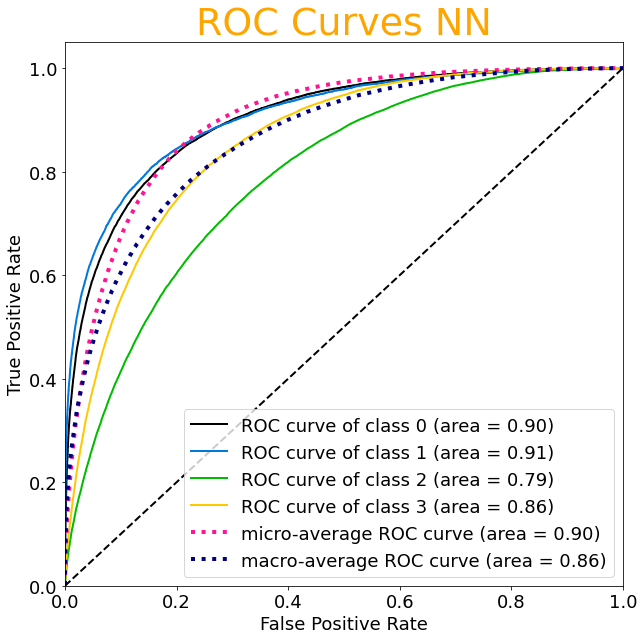

In [195]:
import scikitplot as skplt
import matplotlib.pyplot as plt


y_true = y_test
y_probas = predicitions
skplt.metrics.plot_roc(y_true, y_probas, figsize=(10, 10), text_fontsize=18)
plt.title('ROC Curves NN', fontsize=38, color='orange')

plt.savefig("/Users/francesco/ROC.png", transparent=True, dpi=1000)
plt.show()

# TFIDF Method

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size= 0.2, random_state=1)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

## Training

In [ ]:
'''(Put into a class later)'''
def tfidf(X_data_train, X_data_test, stopwords):
    '''Does TFIDF on training Data.'''
    tfidf_obj = TfidfVectorizer(stop_words = stopwords,
                                sublinear_tf = True,
                                analyzer = 'word',
                                token_pattern = r'\w{2,}',
                                ngram_range = (1, 3),
                                max_features = 25000
                               )
    tvec_mat_train = tfidf_obj.fit_transform(X_data_train)    
    tvec_mat_test = tfidf_obj.transform(X_data_test) 
    tfidf_feature_names = tfidf_obj.get_feature_names()  
    
    return tvec_mat_train, tvec_mat_test, tfidf_feature_names
    
def chi_squared(tvec_mat_train, tvec_mat_test, y_train, y_test, tfidf_feature_names):
    '''Plots the words with highest chi-squared values and returns two new matricies 
    which have the highest chi-squared features.'''
    chi2score = chi2(tvec_mat_train, y_train)[0]
    plt.figure(figsize=(12,8))
    wscores = zip(tfidf_feature_names, chi2score)
    wchi2 = sorted(wscores, key=lambda x:x[1])
    topchi2 = list(zip(*wchi2[-20:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]
    plt.barh(x,topchi2[1], align='center', alpha=0.2)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels)
    plt.xlabel('$\chi^2$')
    
    kbest = SelectKBest(score_func = chi2, k = 15000) # Return top 15000 words as features.
    tvec_mat_train_chi = kbest.fit_transform(tvec_mat_train, y_train)
    tvec_mat_test_chi = kbest.fit_transform(tvec_mat_test, y_test)

    return tvec_mat_train_chi, tvec_mat_test_chi

In [ ]:
'''No stop words.'''
stopwords = nltk.corpus.stopwords.words('english')

tvec_mat_train, tvec_mat_test, tfidf_feature_names = tfidf(X_train['text'],
                                                           X_test['text'], stopwords)

tvec_mat_train_chi, tvec_mat_test_chi = chi_squared(tvec_mat_train, tvec_mat_test,
                                                    y_train, y_test,
                                                    tfidf_feature_names)

## Chi2

In [ ]:
'''Add stop words and return top 15000 words as features.'''
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(('wa', 'ha', 'depression', 'depressive', 'depressed', 'anxiety', 'anxious', 
                  'panic', 'attack','suicide', 'bipolar', 'manic', 'mania', 'hypomania', 
                  'attacks', 'lithium','mg', 'die', 'kill', 'disorder', 'episode', 'episodes', 'polar', 'bi'))

tvec_mat_train, tvec_mat_test, tfidf_feature_names = tfidf(X_train['text'], X_test['text'], 
                                                           stopwords)

tvec_mat_train_chi, tvec_mat_test_chi = chi_squared(tvec_mat_train, tvec_mat_test,
                                                    y_train, y_test,
                                                    tfidf_feature_names)

In [ ]:
print(tvec_mat_train_chi.shape)
print(tvec_mat_test_chi.shape)
print(y_train.shape)
print(y_test.shape)

## Standard Scaler

In [25]:
'''Scale the columns which need to be scaled.'''
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train.loc[:, ~X_train.columns.isin(['text'])]) 
X_test_std = scaler.transform(X_test.loc[:, ~X_train.columns.isin(['text'])]) 

In [41]:
from scipy import sparse

In [42]:
'''Remove columns with low chi2 score from sparse matrix and add them to other variables.'''
num_feats = X_train.loc[:, ~X_train.columns.isin(['text'])].values
X_train_tfidf = sparse.hstack((tvec_mat_train_chi, num_feats))

In [43]:
num_feats = X_test.loc[:, ~X_test.columns.isin(['text'])].values
X_test_tfidf = sparse.hstack((tvec_mat_test_chi, num_feats))

In [ ]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(y_train.shape)
print(y_test.shape)

## Grid Search

In [201]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import mean_squared_error

In [ ]:
def docm(y_true, y_pred, labels=None):
    '''Creates Document Matrix'''
    cm = confusion_matrix(y_true, y_pred)
    if gs.classes_ is not None:
        cols = ['p_' + c for c in gs.classes_]
        df = pd.DataFrame(cm, index=gs.classes_, columns=cols)
    else:
        cols = ['p_' + str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=gs.classes_)
    return df

In [ ]:
'''Models and their grid-search parameters.'''
########################################################################
LR = LogisticRegression(multi_class = 'ovr', 
                        random_state = 1,
                        n_jobs=16
                       )
LR_params = {'C': np.logspace(-5, 5, 5),
             'solver': ['lbfgs', 'saga'],
             'max_iter': [500, 1000],
             'penalty': ['l1', 'l2']
            }

########################################################################

SVM_SGD = SGDClassifier(penalty='l2',
                        random_state=1,
                        learning_rate='optimal',
                        tol=None,
                        n_jobs=16
                       )
SVM_SGD_params = {'loss': ['hinge', 'squared_hinge'],
                  'alpha': np.linspace(1e-3, 0.5, 5),
                  'max_iter': [500, 1000],
                  'penalty': ['l1', 'l2', 'elasticnet']
                 }

########################################################################

KNC = KNeighborsClassifier(n_jobs=16
                          )
KNC_params = {'algorithm': ['auto'],
              'n_neighbors': [2, 10, 20],
              'p': [1, 2],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']
             }

########################################################################

RFC = RandomForestClassifier(random_state=1,
                             n_estimators=100,
                             n_jobs=16
                            )
RFC_params = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 5],
              'ccp_alpha': np.linspace(0., 0.5, 3)
             }

########################################################################

ETC = ExtraTreesClassifier(random_state=1,
                           n_estimators=100,
                           n_jobs=16
                          )
ETC_params = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 5],
              'ccp_alpha': np.linspace(0., 0.5, 3)
             }

########################################################################

DTC = DecisionTreeClassifier(random_state=1
                            )
DTC_params = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 5],
              'ccp_alpha': np.linspace(0., 0.5, 3)
             }

########################################################################

In [ ]:
'''Grid Search'''

models = {'LogisticRegression': LR, 
          'SGDClassifier': SVM_SGD, 
          'KNeighborsClassifier': KNC,
          'DecisionTreeClassifier': DTC, 
          'RandomForestClassifier': RFC, 
          'ExtraTreeClassifier': ETC
         }

params = {'LogisticRegression': LR_params, 
          'SGDClassifier': SVM_SGD_params, 
          'KNeighborsClassifier': KNC_params,
          'DecisionTreeClassifier': DTC_params, 
          'RandomForestClassifier': RFC_params, 
          'ExtraTreeClassifier': ETC_params
         }

score_list = []
for name, model in models.items():
    accuracy = 0
    gs = GridSearchCV(estimator = model, 
                      param_grid = params[name], 
                      cv=5, 
                      verbose=1,
                      n_jobs=16
                     )
    
    gs.fit(X_train_tfidf, y_train)
    
    best_est = gs.best_estimator_
    best_score = gs.best_score_ 
    best_params = gs.best_params_
    
    train_score = gs.score(X_train_tfidf, y_train)
    test_score = gs.score(X_test_tfidf, y_test)
    
    test_predictions = gs.predict(X_test_tfidf)
    
    gs_results = pd.DataFrame(gs.cv_results_)
    score_list.append([name, train_score, test_score, best_score]) # Append main results of best estimator.
    
    joblib.dump(gs, f'{name}' + '_model.jlib') # Save model.
    gs_results.to_csv(f'{name}' + '_results', encoding='utf-8', index=False) # Export results to csv.
         
    # Print reports.
    print(name)
    print()
    print(best_score)
    print()
    print(classification_report(y_test, test_predictions, target_names=gs.classes_))
    print()
    print(docm(y_test, test_predictions))
    print()
    print('-'*80)

In [ ]:
df_scores = pd.DataFrame(score_list, columns=['model', 'train_score', 'test_score', 'best_score']) # Dataframe of main scores.
df_scores

df_scores.to_csv('/Users/francesco/df_scores', encoding='utf-8', index=False)

## Neural Network

In [39]:
d = dict(zip(df.subreddit.unique(), range(0,4)))
d

{'Anxiety': 0, 'bipolar': 1, 'depression': 2, 'SuicideWatch': 3}

In [ ]:
y_train = y_train.map(d, na_action='ignore')
y_test = y_test.map(d, na_action='ignore')

In [43]:
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
np.random.seed(1337)

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import multi_gpu_model 

In [45]:
keras.backend.backend()

'plaidml'

In [235]:
model = keras.Sequential()
alpha = 0.001

model.add(keras.layers.Dense(256, activation='relu', input_shape=(X_train_std.shape[1], ), kernel_regularizer=keras.regularizers.l2(alpha))) 
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(alpha)))
# model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(alpha)))
model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(alpha)))

model.add(keras.layers.Dense(4, activation='softmax', kernel_regularizer=keras.regularizers.l2(alpha)))

optimizer = keras.optimizers.SGD(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [236]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

EPOCHS = 100

history = model.fit(
  X_train_tfidf, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=1, callbacks=[early_stop], batch_size=256)

Train on 502808 samples, validate on 125703 samples
Epoch 1/100
502808/502808 [==============================] - 21s 41us/step - loss: 1.0196 - acc: 0.6511 - val_loss: 0.8747 - val_acc: 0.6646
Epoch 2/100
502808/502808 [==============================] - 17s 34us/step - loss: 0.8609 - acc: 0.6695 - val_loss: 0.8692 - val_acc: 0.6651
Epoch 3/100
502808/502808 [==============================] - 18s 36us/step - loss: 0.8537 - acc: 0.6727 - val_loss: 0.8584 - val_acc: 0.6713
Epoch 4/100
502808/502808 [==============================] - 18s 36us/step - loss: 0.8504 - acc: 0.6745 - val_loss: 0.8486 - val_acc: 0.6743
Epoch 5/100
502808/502808 [==============================] - 17s 35us/step - loss: 0.8494 - acc: 0.6757 - val_loss: 0.8490 - val_acc: 0.6777
Epoch 6/100
502808/502808 [==============================] - 17s 35us/step - loss: 0.8483 - acc: 0.6763 - val_loss: 0.8626 - val_acc: 0.6713
Epoch 7/100
502808/502808 [==============================] - 17s 34us/step - loss: 0.8475 - acc: 0.676

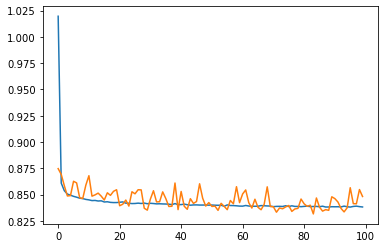

In [238]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [239]:
predicitions = model.predict(X_test_std)

In [240]:
model.metrics_names

['loss', 'acc']

In [241]:
model.evaluate(X_test_std, y_test, verbose=2)

[0.846326370369386, 0.6728781630263225]

In [242]:
accuracy_score(y_test, predicitions.argmax(axis=1))

0.6728781630263225

## Visualise Results

In [99]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [53]:
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if model.classes_ is not None:
        cols = ['p_' + c for c in model.classes_]
        df = pd.DataFrame(cm, index=model.classes_, columns=cols)
    else:
        cols = ['p_' + str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=model.classes_)
    return df

In [82]:
inv_d = {v: k for k, v in d.items()}
inv_d

{0: 'Anxiety', 1: 'bipolar', 2: 'depression', 3: 'SuicideWatch'}

In [94]:
y_test = y_test.map(inv_d, na_action='ignore')
y_test

26181       depression
651520    SuicideWatch
148228         Anxiety
362498      depression
9594        depression
              ...     
365813    SuicideWatch
206708      depression
417665      depression
581006      depression
270883    SuicideWatch
Name: subreddit, Length: 157128, dtype: object

In [149]:
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if d.keys() is not None:
        cols = [c for c in d.keys()]
        df = pd.DataFrame(cm, index=d.keys(), columns=cols)
    else:
        cols = [str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=d.keys())
    return df

In [471]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import itertools
    plt.figure(figsize=(13, 13))
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('BuGn')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.title('Confusion Matrix', fontsize=38, color='orange')
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=18)
    plt.tight_layout()
    plt.savefig("/Users/francesco/cmat_.png", transparent=False, dpi=300)
    
    plt.show()

<Figure size 936x936 with 0 Axes>

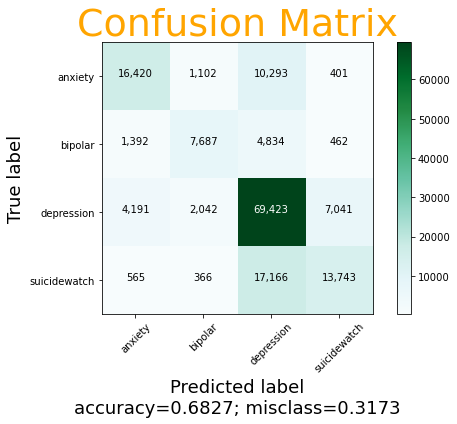

In [472]:
plot_confusion_matrix(cm           = np.array([[16420,  1102,   10293, 401],
                                              [1392,  7687,  4834, 462],
                                              [4191,  2042, 69423, 7041],
                                              [565, 366, 17166, 13743]]), 
                      normalize    = False,
                      target_names = ['anxiety', 'bipolar', 'depression', 'suicidewatch'],
                      title        = "Confusion Matrix NN")

In [151]:
print(classification_report(y_test, predicitions.argmax(axis=1), target_names=d.keys()))
print()
print(docm(y_test, predicitions.argmax(axis=1)))

              precision    recall  f1-score   support

     Anxiety       0.73      0.58      0.65     28216
     bipolar       0.69      0.53      0.60     14375
  depression       0.68      0.84      0.75     82697
SuicideWatch       0.63      0.43      0.51     31840

    accuracy                           0.68    157128
   macro avg       0.68      0.60      0.63    157128
weighted avg       0.68      0.68      0.67    157128


              Anxiety  bipolar  depression  SuicideWatch
Anxiety         16420     1102       10293           401
bipolar          1392     7687        4834           462
depression       4191     2042       69423          7041
SuicideWatch      565      366       17166         13743


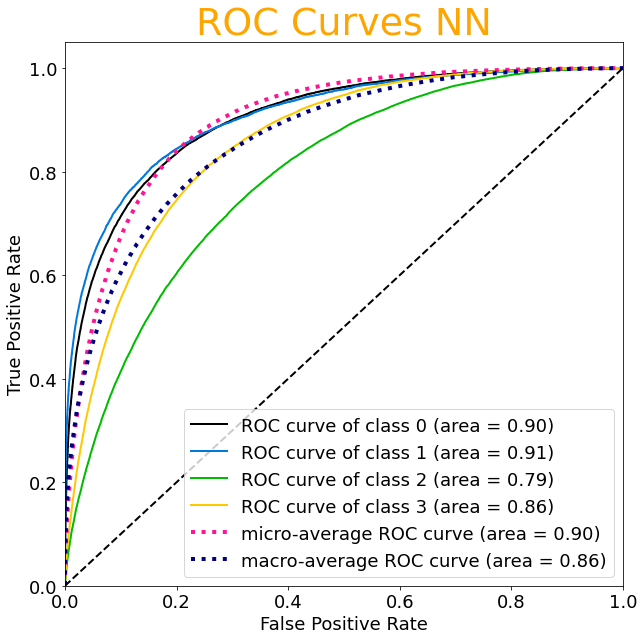

In [195]:
import scikitplot as skplt
import matplotlib.pyplot as plt


y_true = y_test
y_probas = predicitions
skplt.metrics.plot_roc(y_true, y_probas, figsize=(10, 10), text_fontsize=18)
plt.title('ROC Curves NN', fontsize=38, color='orange')

plt.savefig("/Users/francesco/ROC.png", transparent=True, dpi=300)
plt.show()

# Oversampling (if desired)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [ ]:
cat_cols = list(range(25000, 25043)) # Columns which are categorical
cat_cols

In [ ]:
sm = SMOTENC(sampling_strategy = 'not majority', # Resample the minority class.
             random_state = 1, 
             n_jobs = -1, 
             categorical_features = cat_cols)

In [ ]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)

scores=[]
for train_index, test_index in cv.split(X_train_pca, y_train):
    # Get the training data
    X_train_fold, y_train_fold = X_train.tocsr(train_index), y_train[train_index]
    X_test_fold, y_test_fold = X_train.tocsr(test_index), y_train[test_index]
    
    Upsample only the data in the training section
    X_train_over, y_train_over = sm.fit_resample(X_train_fold, y_train_fold)
    
    model = logreg
    model.fit(X_train_over,y_train_over)
    scores.append(model.score(X_test_fold, y_test_fold))

In [ ]:
'''Upsample only the data in the training section.'''
X_train_over, y_train_over = sm.fit_sample(X_train, y_train)

In [ ]:
print(X_train_over.shape)
print(X_test.shape)
print(y_train_over.shape)
print(y_test.shape)

# Lime tfidf

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(('depression', 'depressive', 'depressed', 'anxiety', 'anxious', 
                      'suicide', 'suicidal', 'bipolar', 'bi', 'polar'))

In [ ]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words = stopwords,
                                                             sublinear_tf = True, 
                                                             analyzer = 'word',
                                                             token_pattern = r'\w{2,}',
                                                             ngram_range = (1, 3),
                                                             max_features = 25000
                                                            )

In [337]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, model)

In [338]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=model.classes_)

In [278]:
model.classes_

array(['Anxiety', 'SuicideWatch', 'bipolar', 'depression'], dtype=object)

In [222]:
train = pd.concat([X_train, y_train], axis=1)
train.head()

text  num_comments  \
316560  i am currently just bored of everything doing ...           3.0   
514456  it hurts so bad i have been crying the whole a...           2.0   
51968   suicide note either for the present or future ...           3.0   
352037  oh cool just had an anxiety attack over absolu...           0.0   
598643  hell is being alive hell is being alive eating...           5.0   

        score  word_count  vader_compound    CC   CD    DT   EX   FW  ...  \
316560    1.0        58.0          0.3803   4.0  0.0   3.0  0.0  0.0  ...   
514456    2.0       128.0         -0.9813  11.0  0.0  10.0  0.0  0.0  ...   
51968     3.0       517.0         -0.9949  21.0  0.0  39.0  0.0  0.0  ...   
352037    1.0        31.0          0.0302   0.0  0.0   1.0  0.0  0.0  ...   
598643   18.0        73.0         -0.7180   3.0  0.0   6.0  1.0  0.0  ...   

         VBD   VBG   VBN   VBP   VBZ  WDT   WP  WP$  WRB     subreddit  
316560   0.0   3.0   4.0   6.0   0.0  0.0  0.0  0.0  0.0    depression  
514456   0.0   3.0   3.0  10.0   3.0  0.0  0.0  0.0  0.0    depression  
51968   10.0  12.0  14.0  40.0  13.0  2.0  4.0  0.0  8.0  SuicideWatch  
352037   4.0   2.0   0.0   0.0   3.0  1.0  0.0  0.0  0.0       Anxiety  
598643   2.0   3.0   2.0   9.0   5.0  0.0  0.0  0.0  0.0  SuicideWatch  

[5 rows x 42 columns]

In [223]:
test = pd.concat([X_test, y_test], axis=1)
test.head()

text  num_comments  \
26181   nobody gives a shit about me my existence is m...          17.0   
651520  i know how to beat this i do not want to i do ...           6.0   
148228  i do nothing and my anxiety is telling me to d...           2.0   
362498  how do i change my self from a people pleasing...           0.0   
9594    brush id but i feel like i am on a speeding tr...           1.0   

        score  word_count  vader_compound    CC   CD    DT   EX   FW  ...  \
26181    98.0        32.0         -0.9201   2.0  0.0   2.0  0.0  0.0  ...   
651520    5.0       142.0          0.2200   6.0  0.0   7.0  0.0  0.0  ...   
148228    2.0       243.0          0.9709  13.0  1.0   8.0  3.0  0.0  ...   
362498    1.0       217.0         -0.9856  13.0  2.0  19.0  0.0  0.0  ...   
9594      6.0        41.0         -0.8569   4.0  0.0   1.0  0.0  0.0  ...   

        VBD  VBG  VBN   VBP   VBZ  WDT   WP  WP$  WRB     subreddit  
26181   2.0  2.0  2.0   1.0   2.0  0.0  0.0  0.0  0.0    depression  
651520  0.0  0.0  2.0  17.0   4.0  0.0  2.0  0.0  2.0  SuicideWatch  
148228  4.0  9.0  6.0  13.0  12.0  1.0  3.0  0.0  3.0       Anxiety  
362498  2.0  2.0  1.0  14.0   7.0  0.0  3.0  0.0  1.0    depression  
9594    1.0  4.0  1.0   5.0   0.0  0.0  0.0  0.0  0.0    depression  

[5 rows x 42 columns]

In [224]:
test = test.iloc[:, [0, -1]]
train = train.iloc[:, [0, -1]]

In [332]:
train_vectors = vectorizer.fit_transform(train.text)
test_vectors = vectorizer.transform(test.text)

In [232]:
train.subreddit

316560      depression
514456      depression
51968     SuicideWatch
352037         Anxiety
598643    SuicideWatch
              ...     
61382       depression
428258         bipolar
17418          Anxiety
673303    SuicideWatch
723666      depression
Name: subreddit, Length: 628511, dtype: object

In [334]:
model = LR.fit(train_vectors, train.subreddit)
print('model done')
# cv_score = cross_val_score(model, X_train_std, y_train, cv=3).mean()

# print(cv_score)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/francesco/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/francesco/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documen

model done


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 24.8min finished


In [404]:
idx = 360
print(test.text.iloc[idx])
exp = explainer.explain_instance(test.text.iloc[idx], c.predict_proba, num_features=6, top_labels=4)

print() 
exp.show_in_notebook(text=True)

i think everybody secretly hates me my anxiety is so bad to the point where whenever i see people whispering or gossiping i always assume it is about me and feel like they hate me or they are judging me i think it comes from my bad high school experience where i had that happen to me and i was always seeing girls whispering and staring at me whilst they were making fun of me i just do not know how it turn it off and stop being so paranoid that everyone secretly hates me it makes me feel crazy 



In [365]:
idx = 15244
print(test.text.iloc[idx])
exp = explainer.explain_instance(test.text.iloc[idx], c.predict_proba, num_features=6, top_labels=4)

print()
exp.show_in_notebook(text=True)

why now why does it always come back why is it that i start slipping back into depression whenever i try to better my life so many lost opportunities and friendships to this damn illness i do not even know why i bother trying to better myself anymore i will just pick myself up enough to fall harder and lose more of my will to keep going i really am useless i will never be worth anyone time i am tired of trying i just want this to end 

